In [320]:
#! pip install numpy pandas ipywidgets tqdm PyQt6 scipy gymnasium "gymnasium[other]" "gymnasium[classic-control]"

#### Imports

In [321]:
from typing import Optional
import numpy as np
import gymnasium as gym
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle
from IPython.display import display, clear_output
import copy
from scipy.ndimage import zoom
from tqdm.notebook import tqdm
import pandas as pd
from collections import defaultdict
import math

N_EPISODES = 3000
UPDATE_STEP = 1     # Update q_values after each step
BETA = 0.6
ALPHA = 0.1
GAMMA = 0.9
SIZE = 30
STEPS = SIZE * SIZE
EPSILON = 0.8
EVALUATION_STEPS = SIZE * SIZE
EVALUATION_EPISODES = 10

# Fix liste:
# TODO: Forstå boltzmann Beta
# TODO: kan gå ind i væg uden at blive punsihed.
# TODO: Implement brushfire paa heatmap.



#spørgsmål
# TODO: bland visit_near og nearby agent sammen? mindre Q table?
# TODO: en form for memory? eller skal den bare "gå i blinde" til den finder en reward?





#### World class

In [322]:
class GridWorldEnv(gym.Env):

    def __init__(self, size: int = 10):
        # The size of the square grid
        self.size = size
        self.trajectory = []
        self.world = np.zeros((size, size))
        self.visited_states = np.zeros((size, size))
        self.global_location = np.zeros((size, size))
        self.POI_world = np.zeros((size, size))


        # Define the agent and target location; randomly chosen in `reset` and updated in `step`
        self._agent_location = np.array([1, 1], dtype=np.int32)
        self._visited_states_near = np.zeros((5, 5))
        self._reward_near = np.zeros(8)
        self._nearby_agent = np.zeros((5,5))
        self._POI_direction = np.zeros(8)
        self._world_border = (size, size)
        


        # Observations are dictionaries with the agent's and the target's location.
        self.observation_space = gym.spaces.Dict(
            {
            "visited_states_near": gym.spaces.Box(0, 1, shape=(5, 5), dtype=int),
            "reward_near": gym.spaces.Box(0, 10, shape=(0, 8), dtype=int),
            "nearby_agent": gym.spaces.Box(0, 1, shape=(5, 5), dtype=int),
            "POI_direction": gym.spaces.Box(0, 1, shape=(8,), dtype=int),
            }
        )

        # We have 8 actions, corresponding to "right", "up", "left", "down" and diagonal
        self.action_space = gym.spaces.Discrete(8)
        # Dictionary maps the abstract actions to the directions on the grid
        self._action_to_direction = {
            0: np.array([1, 0]),  # right
            1: np.array([0, 1]),  # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
            4: np.array([1, 1]),  # up-right
            5: np.array([-1, 1]),  # up-left
            6: np.array([-1, -1]),  # down-left
            7: np.array([1, -1]),  # down-right
        }
    
    def normalize_env_reward(self):
        # Normalize the world to be between 0 and 1
        min_val = 0
        max_val = 10
        self.world = (self.world - min_val) / (max_val - min_val)

    def scale_env(self):
        # Scale all rewards to be between 0 and 10
        min_val = np.min(self.world)
        max_val = np.max(self.world)
        self.world = (self.world - min_val) / (max_val - min_val) * 10
        self.world = np.round(self.world, 0)

    def state_penalize(self):
        x, y = self._agent_location
        if(self.world[x][y] > 0):
            self.world[x][y] -= self.world[x][y] + 2
        else:
            self.world[x][y] -= 2

    def random_env(self):
        self.world = np.random.randint(1, 11, size=(self.size, self.size))

    def heatmap_env(self):
        with open("../Kaspers_chad_pdfer_mm/heatmap/data/heatmap.pkl", "rb") as f:
            heatmap = np.rot90(pickle.load(f), k=1)
        
        heatmap_scaled = zoom(heatmap, (self.size / heatmap.shape[0], self.size / heatmap.shape[1]), order=1)  # Bilinear interpolation

        self.world = heatmap_scaled
        # self.normalize_env_reward()
        self.scale_env()
    
    def reset_visited_states(self):
        self.visited_states = np.zeros((self.size, self.size))
    
    def world_from_matrix(self, matrix):
        self.world = matrix

    def setReward(self, x, y , reward):
        self.world[x][y] = reward

    def _get_info(self):
        return {
            "agent_location": self._agent_location,
            "world_border": self._world_border,
        }

    def _get_obs(self):
        return {
            "visited_states_near": self._visited_states_near,
            "reward_near": self._reward_near,
            "nearby_agent": self._nearby_agent,
            "POI_direction": self._POI_direction,
        }
    

    def reset_global_location(self):
        self.global_location = np.zeros((self.size, self.size))

    def reset(self, agents, seed: Optional[int] = None, options: Optional[dict] = None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        self._agent_location = self.np_random.integers(0, self.size -1, size=2, dtype=int)
        # reset visited states near and reward_near
        self.reset_visited_states()
        self.reset_global_location()


        observation = self._get_obs()
        info = self._get_info()

        return observation, info
    
    def spawn_agents_random(self, agents, seed: Optional[int] = None, options: Optional[dict] = None):
        for agent in agents:
            # We need the following line to seed self.np_random
            super().reset(seed=seed)

            agent.location = self.np_random.integers(0, self.size -1, size=2, dtype=int) 
        

    def getReward(self):
        return self.world[self._agent_location[0], self._agent_location[1]]


    def check_rewards_near(self):
        x, y = self._agent_location
        rewards = []
        for dx, dy in self._action_to_direction.values():
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.size and 0 <= ny < self.size:
                rewards.append(self.world[nx][ny])
            else:
                rewards.append(-np.inf)

        # Find the index of the maximum reward
        max_reward_index = np.argmax(rewards)

        self._reward_near = np.zeros(8)
        self._reward_near[max_reward_index] = 1

    def check_visited_near(self):
        # Create a 3x3 local view centered on the agent
        x, y = self._agent_location

        for dx in range(-2, 3):
            for dy in range(-2, 3):
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.size and 0 <= ny < self.size:
                    self._visited_states_near[dx + 2, dy + 2] = self.visited_states[nx][ny]

    def update_global_location(self):
        self.global_location[self._agent_location[0], self._agent_location[1]] = 1

    def check_nearby_agents(self):
        """Checks for other agents in a 5x5 grid centered on the agent."""
        x, y = self._agent_location

        for dx in range(-2, 3): 
            for dy in range(-2, 3):
                nx, ny = x + dx, y + dy

                # Check if within bounds
                if 0 <= nx < self.size and 0 <= ny < self.size:
                    self._nearby_agent[dx + 2, dy + 2] = self.global_location[nx][ny]

    def set_POI(self, x, y):
        self.POI_world[x][y] = 1

    def get_POI_direction(self):
        agent_x, agent_y = self._agent_location

        # Find the coordinates of the POI (assuming one POI with value 1 in self.POI_world)
        poi_coords = np.argwhere(self.POI_world == 1)
        if len(poi_coords) == 0:
            # No POI set
            self._POI_direction = np.zeros(8)
            return
        # Take the first one (you can expand this to handle multiple POIs)
        poi_x, poi_y = poi_coords[0]
        dx = poi_x - agent_x
        dy = poi_y - agent_y

        # Normalize direction to one of 8 compass directions
        if dx != 0:
            dx = dx // abs(dx)
        if dy != 0:
            dy = dy // abs(dy)

        # Find the matching index in _action_to_direction
        direction_vector = np.array([dx, dy])
        direction_index = None
        for index, (ddx, ddy) in self._action_to_direction.items():
            if np.array_equal(direction_vector, np.array([ddx, ddy])):
                direction_index = index
                break

        # Create direction vector
        self._POI_direction = np.zeros(8)
        if direction_index is not None:
            self._POI_direction[direction_index] = 1


    def remove_POI(self):
        x, y = self._agent_location
        if(self.POI_world[x][y] > 0):
            self.POI_world[x][y] = 0



    def step(self, action, agent):
        # Map the action (element of {0,1,2,3,4,5,6,7}) to the direction we walk in
        direction = self._action_to_direction[action]

         # --- Update `visited_states` ---
        grid_x, grid_y = self._agent_location
        self.visited_states[grid_x][grid_y] = 1
    
        # Reset agent location for nearby agent observation
        self.global_location[agent.location[0], agent.location[1]] = 0

        # We use `np.clip` to make sure we don't leave the grid bounds
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )

        agent.location = np.clip(
            agent.location + direction, 0, self.size - 1
        )

        self.global_location[agent.location[0], agent.location[1]] = 1

        self.check_visited_near()
        self.check_rewards_near()
        self.check_nearby_agents()
        self.get_POI_direction()

        # An environment is completed if and only if the agent has searched all states
        terminated = False
        truncated = False
        reward = self.getReward()
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info
    
    

#### Agent Class
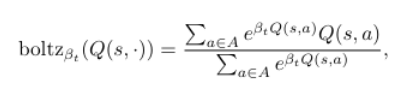

In [323]:
class SAR_agent:
    def __init__(
        self,
        agent_id,
        env: gym.Env,
        alpha: float,
        beta,
        epsilon,
        gamma: float = 0.0
    ):
        self.agent_id = agent_id
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.location = np.array([-1, -1], dtype=np.int32)

        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.beta = beta

        self.trajectory = []
        self.training_error = []

    def reset_trajectory(self):
        self.trajectory = []

    def agent_spawn(self, info):
        location = info['agent_location']
        print("Spawn", self.agent_id, location)
        self.location = location

    def add_trajectory(self, info):
        location = self.location
        print("Adding traj", self.agent_id, location)
        self.trajectory.append(location)
        
    def get_state(self, obs: dict):
        visited_states_near = obs["visited_states_near"]
        reward_near = obs["reward_near"]
        nearby_agent = obs["nearby_agent"]

        return (
            np.sum(visited_states_near),
            tuple(reward_near.flatten()),
            np.sum(nearby_agent)
        )

    def mega_greedy_swarm_action(self, obs: dict, info: dict) -> int:
        agent_state = self.get_state(obs)
        q_values = self.q_values[agent_state]


        agent_loc = self.location
        world_border = info["world_border"]  # (size_x, size_y)
        size_x, size_y = world_border

        # Get list of valid actions
        valid_actions = []
        for action, (dx, dy) in self.env._action_to_direction.items():
            nx, ny = agent_loc[0] + dx, agent_loc[1] + dy
            if 0 <= nx < size_x and 0 <= ny < size_y:
                valid_actions.append(action)

        # Mask out invalid actions by setting them to a very low value
        masked_q_values = np.full_like(q_values, -np.inf)
        for a in valid_actions:
            masked_q_values[a] = q_values[a]



        return int(np.argmax(masked_q_values))

    def get_action_boltz(self, obs: dict, info: dict) -> int:
        agent_state = self.get_state(obs)

        q_values = self.q_values[agent_state]

        # --- Action Masking based on world borders ---
        agent_loc = self.location
        world_border = info["world_border"]  # assuming tuple (size, size)
        size_x, size_y = world_border
        valid_actions = []

        for action, (dx, dy) in self.env._action_to_direction.items():
            nx, ny = agent_loc[0] + dx, agent_loc[1] + dy
            if 0 <= nx < size_x and 0 <= ny < size_y:
                valid_actions.append(action)

        # Build a mask
        mask = np.zeros_like(q_values)
        mask[valid_actions] = 1

        exp_q = np.exp(self.beta * q_values - np.max(self.beta * q_values))
        exp_q *= mask 

    
        boltzmann_probs = exp_q / np.sum(exp_q)

        return np.random.choice(len(q_values), p=boltzmann_probs)

    def get_action_epsilon(self, obs: dict) -> int:
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            agent_state = self.get_state(obs)
            return int(np.argmax(self.q_values[agent_state]))

    def update(
        self,
        obs: dict,  
        action: int,
        reward: float,
        terminated: bool,
        next_obs: dict  
    ):
        agent_state = self.get_state(obs)
        next_agent_state = self.get_state(next_obs)

        future_q_value = (not terminated) * np.max(self.q_values[next_agent_state])

        temporal_difference = (
            reward + self.gamma * future_q_value - self.q_values[agent_state][action]
        )

        self.q_values[agent_state][action] += self.alpha * temporal_difference
        self.training_error.append(temporal_difference)


    def plot_trajectory(self, time_step):
        plt.figure()
        for i, state in enumerate(self.trajectory):
            clear_output(wait=True)
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.title("Agent's Trajectory Simulation")
            plt.grid(True)
            
            past_x, past_y = zip(*self.trajectory[: i + 1])
            plt.plot(past_x, past_y, "bo-", label="Past Path")

            plt.plot(state[0], state[1], "ro", markersize=10, label="Current Position")
            
            plt.legend()
            plt.xlim(-1, self.env.size + 1)
            plt.ylim(-1, self.env.size + 1)
            plt.pause(time_step)
        
        plt.show()

#### Swarm Class

In [324]:
class swarm:
    def __init__(self, env, agents, n_episodes, update_step=1):
        self.env = env
        self.agents = agents
        self.visited_states = [[0 for _ in range(env.size)] for _ in range(env.size)]
        self.cum_reward = []    # :TODO overvej nyt navn
        self.episode_cum_reward = [0 for _ in range(N_EPISODES)]
        self.n_episodes = n_episodes
        self.revisits = []
        self.info_pr_episode = []
        self.update_step = update_step
        self.episode_trajectory = []
        self.info_pr_step = []

    def state_visited(self, obs):
        x, y = obs['agent']
        self.visited_states[y][x] = 1

    def swarm_spawn_random(self, info):
        self.env.spawn_agents_random(self.agents)
        for agent in self.agents:
            agent.trajectory.append(agent.location)

    def swarm_spawn_uniform(self, info):
        for agent in self.agents:
            agent.agent_spawn(info)

    def state_has_been_visited(self, obs):
        x, y = obs['agent']
        return self.visited_states[y][x] == 1

    def reset_trajectory(self):
        for agent in self.agents:
            agent.reset_trajectory()

    def calc_revisits(self, train_env):
        revisited = 0
        for i in range(train_env.size):
            for j in range(train_env.size):
                revisited += train_env.visited_states[i][j]
        self.revisits.append(revisited)
    
    def calc_info_pr_step(self,train_env):
        visited_rewards = 0
        for i in range(train_env.size):
            for j in range(train_env.size):
                visited_rewards += self.env.world[i][j] * train_env.visited_states[i][j]
        total_rewards = np.sum(self.env.world)
        return visited_rewards / total_rewards

    def calc_info_pr_episode(self, train_env, steps):
        visited_rewards = 0
        for i in range(train_env.size):
            for j in range(train_env.size):
                visited_rewards += self.env.world[i][j] * train_env.visited_states[i][j]
        total_rewards = np.sum(self.env.world)
        
        info_pr_episode = visited_rewards / total_rewards

        self.info_pr_step.append(info_pr_episode/steps)
        self.info_pr_episode.append(info_pr_episode)

    def update_episode_trajectory(self):
        swarm_trajectory = []
        for agent in self.agents:
            swarm_trajectory.append(agent.trajectory)
            print("Spawn location:", agent.trajectory[0])
        self.episode_trajectory.append(swarm_trajectory)

    def train_swarm(self, max_steps):
        progress_bar = tqdm(range(self.n_episodes), desc="Training Progress", unit="episode", leave=False)

        for episode in progress_bar:
            train_env = copy.deepcopy(self.env)
            progress_bar.set_description(f"Training Progress (Episode {episode + 1}/{self.n_episodes})")

            # Reset the environment for the start of the episode
            obs, info = train_env.reset(self.agents)
            self.swarm_spawn_uniform(info)
            
            self.cum_reward = 0
            terminated = False
            steps = 0
            done = False

            # Run the episode until termination
            while not done:

                for agent in self.agents:
                    train_env.state_penalize()
                    train_env.remove_POI()

                    action = agent.get_action_boltz(obs,info)

                    next_obs, reward, terminated, truncated, info = train_env.step(action, agent)

                    if(steps % self.update_step == 0):
                        agent.update(obs, action, reward, terminated, next_obs)

                    self.episode_cum_reward[episode] += reward

                    if steps >= max_steps:
                        terminated = True

                    done = terminated or truncated
                    obs = next_obs
                    steps += 1
        
        progress_bar.close()


    def evaluate_swarm(self, max_steps, number_of_episode):
        progress_bar = tqdm(range(number_of_episode), desc="Training Progress", unit="episode", leave=False)
        self.revisits = []

        for episode in progress_bar:
            train_env = copy.deepcopy(self.env)
            progress_bar.set_description(f"Evaluation Progress (Episode {episode + 1}/{number_of_episode})")

            print("new episode")
            # Reset the environment for the start of the episode
            obs, info = train_env.reset(self.agents)
            self.swarm_spawn_uniform(info)
            self.reset_trajectory()
            
            self.cum_reward = 0
            terminated = False
            steps = 0
            done = False

            # Run the episode until termination
            while not done:

                for agent in self.agents:
                    train_env.state_penalize()
                    train_env.remove_POI()

                    action = agent.mega_greedy_swarm_action(obs,info)
                    
                    next_obs, reward, terminated, truncated, info = train_env.step(action, agent)
                    agent.add_trajectory(info)

                    self.episode_cum_reward[episode] += reward

                    if steps >= max_steps or self.calc_info_pr_step(train_env) > 0.8:
                        terminated = True

                    done = terminated or truncated
                    obs = next_obs
                    steps += 1
            
            self.episode_cum_reward.append(self.cum_reward)
            self.calc_revisits(train_env)
            self.calc_info_pr_episode(train_env, steps)
            self.update_episode_trajectory()

        progress_bar.close()

    def plot_reward_episode(self, number_of_episodes, window_size=50):
        """Plots reward per episode with a rolling mean and shaded variance"""
        plt.figure()
        
        x = range(number_of_episodes)
        y = np.array(self.episode_cum_reward[:number_of_episodes])
        
        # Compute rolling mean and standard deviation
        y_smooth = pd.Series(y).rolling(window=window_size, min_periods=1).mean()
        y_std = pd.Series(y).rolling(window=window_size, min_periods=1).std()

        # Plot raw data faintly
        plt.plot(x, y, alpha=0.2, label="Raw Rewards", color='gray')

        # Plot rolling mean
        plt.plot(x, y_smooth, label="Smoothed Rewards", color='red')

        # Shaded area: Mean ± 1 standard deviation
        plt.fill_between(x, y_smooth - y_std, y_smooth + y_std, color='red', alpha=0.2)

        plt.xlabel('Episodes')
        plt.ylabel('Reward')
        plt.title('Reward per Episode')
        plt.legend()
        plt.show()

    def plot_revisited(self, number_of_episodes, window_size=50,):
        """Plots revisits per episode with rolling mean and variance shading"""
        plt.figure()

        x = range(number_of_episodes)
        y = np.array(self.revisits[:number_of_episodes])

        # Compute rolling mean and standard deviation
        y_smooth = pd.Series(y).rolling(window=window_size, min_periods=1).mean()
        y_std = pd.Series(y).rolling(window=window_size, min_periods=1).std()

        # Plot raw data faintly
        plt.plot(x, y, alpha=0.2, label="Raw Revisits", color='gray')

        # Plot rolling mean
        plt.plot(x, y_smooth, label="Smoothed Revisits", color='red')

        # Shaded area: Mean ± 1 standard deviation
        plt.fill_between(x, y_smooth - y_std, y_smooth + y_std, color='red', alpha=0.2)

        plt.xlabel('Episodes')
        plt.ylabel('Revisits')
        plt.title('Revisits per Episode')
        plt.legend()
        plt.show()

    def plot_info(self, number_of_episodes, window_size=50):
        """Plots info gain per episode with rolling mean and variance shading"""
        plt.figure()

        x = range(number_of_episodes)
        y = np.array(self.info_pr_episode[:number_of_episodes])

        # Compute rolling mean and standard deviation
        y_smooth = pd.Series(y).rolling(window=window_size, min_periods=1).mean()
        y_std = pd.Series(y).rolling(window=window_size, min_periods=1).std()

        # Plot raw data faintly
        plt.plot(x, y, alpha=0.2, label="Raw Info Gain", color='gray')

        # Plot rolling mean
        plt.plot(x, y_smooth, label="Smoothed Info Gain", color='red')

        # Shaded area: Mean ± 1 standard deviation
        plt.fill_between(x, y_smooth - y_std, y_smooth + y_std, color='red', alpha=0.2)

        plt.xlabel('Episodes')
        plt.ylabel('Info Gain')
        plt.title('Info Gain per Episode')
        plt.legend()
        plt.show()
    
    def plot_info_pr_step(self, number_of_episodes, window_size=50):
        """Plots info gain per episode with rolling mean and variance shading"""
        plt.figure()

        x = range(number_of_episodes)
        y = np.array(self.info_pr_step[:number_of_episodes])

        # Compute rolling mean and standard deviation
        y_smooth = pd.Series(y).rolling(window=window_size, min_periods=1).mean()
        y_std = pd.Series(y).rolling(window=window_size, min_periods=1).std()

        # Plot raw data faintly
        plt.plot(x, y, alpha=0.2, label="Raw step info", color='gray')

        # Plot rolling mean
        plt.plot(x, y_smooth, label="Smoothed step info", color='red')

        # Shaded area: Mean ± 1 standard deviation
        plt.fill_between(x, y_smooth - y_std, y_smooth + y_std, color='red', alpha=0.2)

        plt.xlabel('Episodes')
        plt.ylabel('Info pr Step')
        plt.title('Info pr step')
        plt.legend()
        plt.show()
    
    def plot_trajectories(self, train_env, num_episodes, episodes_to_plot=None, max_agents=5):
        world_map = train_env.world

        if episodes_to_plot is None:
            episodes_to_plot = list(range(num_episodes))

        num_plots = len(episodes_to_plot)
        cols = 3
        rows = int(np.ceil(num_plots / cols))

        fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4.5 * rows))
        axs = axs.flatten()

        for i, ep_idx in enumerate(episodes_to_plot):
            ax = axs[i]
            ax.imshow(
                world_map.T,
                origin="lower",
                cmap="Greys",
                interpolation="nearest",
                extent=[0, world_map.shape[0], 0, world_map.shape[1]]
            )

            swarm_traj = self.episode_trajectory[ep_idx]
            num_agents = len(self.agents)

            for agent_id in range(num_agents):
                traj = np.array(swarm_traj[agent_id])
                # Plot trajectory line
                ax.plot(traj[:, 0], traj[:, 1], label=f"A{agent_id}", alpha=0.7)
                # Plot spawn point (first position)
                ax.scatter(traj[0, 0], traj[0, 1], s=40, marker='o', edgecolors='k', facecolors='none')

            ax.set_title(f"Episode {ep_idx + 1}")
            ax.set_xlim(0, train_env.size)
            ax.set_ylim(0, train_env.size)
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
            ax.label_outer()

        # Hide unused subplots
        for j in range(i + 1, len(axs)):
            axs[j].axis("off")

        # Shared legend
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.05, 0.5))
        fig.suptitle("Agent Trajectories per Episode (with Spawn Points)", fontsize=16)
        plt.tight_layout(rect=[0, 0, 0.95, 0.95])
        plt.show()


### Hyperparameters

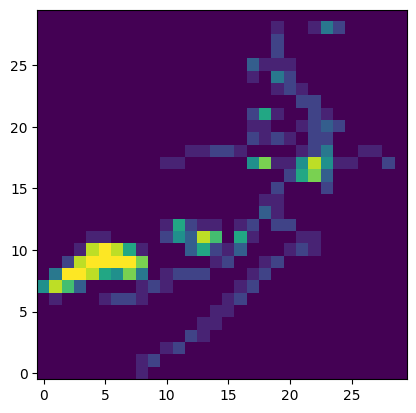

In [325]:
# hyperparameters

env = GridWorldEnv(size=SIZE)

# env.random_env()
# env.setReward(4, 4, 9)
env.heatmap_env()
env.set_POI(8,3)
env.set_POI(9,5)
env.set_POI(9,7)
env.set_POI(11,13)
env.set_POI(17,22)
env.set_POI(17,19)


plt.imshow(env.world, cmap='viridis')
plt.gca().invert_yaxis()
plt.show()

env_timelimit = gym.wrappers.TimeLimit(env, max_episode_steps=1000000)

agent1 = SAR_agent(
    1,
    env=env,
    alpha=ALPHA,
    beta=BETA,
    epsilon=EPSILON,
    gamma=GAMMA
)


agent2 = SAR_agent(
    2,
    env=env,
    alpha=ALPHA,
    beta=BETA,
    epsilon=EPSILON,
    gamma=GAMMA
)

agent3 = SAR_agent(
    3,
    env=env,
    alpha=ALPHA,
    beta=BETA,
    epsilon=EPSILON,
    gamma=GAMMA
)

agent4 = SAR_agent(
    4,
    env=env,
    alpha=ALPHA,
    beta=BETA,
    epsilon=EPSILON,
    gamma=GAMMA
)

agent5 = SAR_agent(
    5,
    env=env,
    alpha=ALPHA,
    beta=BETA,
    epsilon=EPSILON,
    gamma=GAMMA
)

agent6 = SAR_agent(
    6,
    env=env,
    alpha=ALPHA,
    beta=BETA,
    epsilon=EPSILON,
    gamma=GAMMA
)

agent7 = SAR_agent(
    7,
    env=env,
    alpha=ALPHA,
    beta=BETA,
    epsilon=EPSILON,
    gamma=GAMMA
)

agent8 = SAR_agent(
    8,
    env=env,
    alpha=ALPHA,
    beta=BETA,
    epsilon=EPSILON,
    gamma=GAMMA
)

agent9 = SAR_agent(
    9,
    env=env,
    alpha=ALPHA,
    beta=BETA,
    epsilon=EPSILON,
    gamma=GAMMA
)

agents = []
agents.append(agent1)
# agents.append(agent2)
# agents.append(agent3)
# agents.append(agent4)
# agents.append(agent5)

In [326]:
swarm1 = swarm(env, agents, N_EPISODES, UPDATE_STEP)

swarm1.train_swarm(STEPS)

Training Progress:   0%|          | 0/3000 [00:00<?, ?episode/s]

Spawn 1 [ 6 16]
Spawn 1 [11 19]
Spawn 1 [20 14]
Spawn 1 [15 23]
Spawn 1 [13  1]
Spawn 1 [ 5 11]
Spawn 1 [ 1 22]
Spawn 1 [25 12]
Spawn 1 [25 26]
Spawn 1 [20  3]
Spawn 1 [8 3]
Spawn 1 [27 28]
Spawn 1 [3 5]
Spawn 1 [ 1 10]
Spawn 1 [24  9]
Spawn 1 [13 17]
Spawn 1 [17 14]
Spawn 1 [20  4]
Spawn 1 [20 25]
Spawn 1 [17 22]
Spawn 1 [ 8 19]
Spawn 1 [26 22]
Spawn 1 [27 16]
Spawn 1 [21  4]
Spawn 1 [10 18]
Spawn 1 [ 6 22]
Spawn 1 [16  5]
Spawn 1 [10 17]
Spawn 1 [14 10]
Spawn 1 [24 16]
Spawn 1 [28  4]
Spawn 1 [20 27]
Spawn 1 [6 9]
Spawn 1 [ 6 20]
Spawn 1 [19 16]
Spawn 1 [14 23]
Spawn 1 [26  7]
Spawn 1 [15  0]
Spawn 1 [ 6 20]
Spawn 1 [1 8]
Spawn 1 [28  8]
Spawn 1 [25  0]
Spawn 1 [16 16]
Spawn 1 [ 2 13]
Spawn 1 [10  5]
Spawn 1 [26 11]
Spawn 1 [24 23]
Spawn 1 [22  3]
Spawn 1 [19 20]
Spawn 1 [13  3]
Spawn 1 [19  3]
Spawn 1 [ 5 11]
Spawn 1 [16 26]
Spawn 1 [ 3 16]
Spawn 1 [15 14]
Spawn 1 [10 27]
Spawn 1 [ 4 19]
Spawn 1 [28 19]
Spawn 1 [17 11]
Spawn 1 [25 28]
Spawn 1 [15 18]
Spawn 1 [16 22]
Spawn 1 [7 6]
Sp

#### Evaluation

'Q-table'

0.0   \
  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
                                       0.0   
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
5                                      0.0   
6                                      0.0   
7                                      0.0   

                                      1.0   \
  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
                                       1.0   
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
5                                      0.0   
6                                      0.0   
7                                      0.0   

                                            \
  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
                                       1.0   
0                                 0.704488   
1                                 0.251730   
2                                 0.910672   
3                                 0.737695   
4                                 0.370975   
5                                 0.193111   
6                                 0.210044   
7                                 0.279780   

                                      2.0   \
  (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)   
                                       1.0   
0                                30.488639   
1                                27.523949   
2                                30.394471   
3                                33.661473   
4                                33.467833   
5                                28.007928   
6                                33.776646   
7                                30.975072   

                                            \
  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
                                       1.0   
0                                28.267461   
1                                28.289324   
2                                30.227597   
3                                29.606203   
4                                28.020965   
5                                27.810168   
6                                28.260615   
7                                27.991796   

                                            \
  (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
                                       1.0   
0                                31.309831   
1                                32.636418   
2                                30.397394   
3                                32.973945   
4                                31.612501   
5                                28.540161   
6                                29.395414   
7                                31.535593   

                                      3.0   \
  (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
                                       1.0   
0                                23.160002   
1                                26.737094   
2                                26.710665   
3                                24.530791   
4                                23.399756   
5                                26.174620   
6                                22.276618   
7                                23.518658   

                                            \
  (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
                                       1.0   
0                                23.410463   
1                                23.977789   
2                                23.611629   
3                                23.572302   
4                                23.534689   
5                                20.770673   
6                                21.795923   
7                            

[]

Training Progress:   0%|          | 0/10 [00:00<?, ?episode/s]

new episode
Spawn 1 [ 1 25]
Adding traj 1 [ 2 25]
Adding traj 1 [ 3 25]
Adding traj 1 [ 2 25]
Adding traj 1 [ 2 26]
Adding traj 1 [ 1 26]
Adding traj 1 [ 1 27]
Adding traj 1 [ 2 27]
Adding traj 1 [ 3 26]
Adding traj 1 [ 4 26]
Adding traj 1 [ 5 26]
Adding traj 1 [ 4 26]
Adding traj 1 [ 4 27]
Adding traj 1 [ 5 27]
Adding traj 1 [ 6 27]
Adding traj 1 [ 5 27]
Adding traj 1 [ 5 28]
Adding traj 1 [ 6 27]
Adding traj 1 [ 7 26]
Adding traj 1 [ 6 26]
Adding traj 1 [ 5 26]
Adding traj 1 [ 5 25]
Adding traj 1 [ 6 25]
Adding traj 1 [ 7 25]
Adding traj 1 [ 8 25]
Adding traj 1 [ 9 25]
Adding traj 1 [ 8 25]
Adding traj 1 [ 8 26]
Adding traj 1 [ 9 26]
Adding traj 1 [10 26]
Adding traj 1 [ 9 26]
Adding traj 1 [ 9 27]
Adding traj 1 [10 27]
Adding traj 1 [11 26]
Adding traj 1 [12 26]
Adding traj 1 [11 26]
Adding traj 1 [11 27]
Adding traj 1 [12 27]
Adding traj 1 [13 27]
Adding traj 1 [12 27]
Adding traj 1 [12 28]
Adding traj 1 [13 28]
Adding traj 1 [14 27]
Adding traj 1 [15 27]
Adding traj 1 [14 27]
Addi

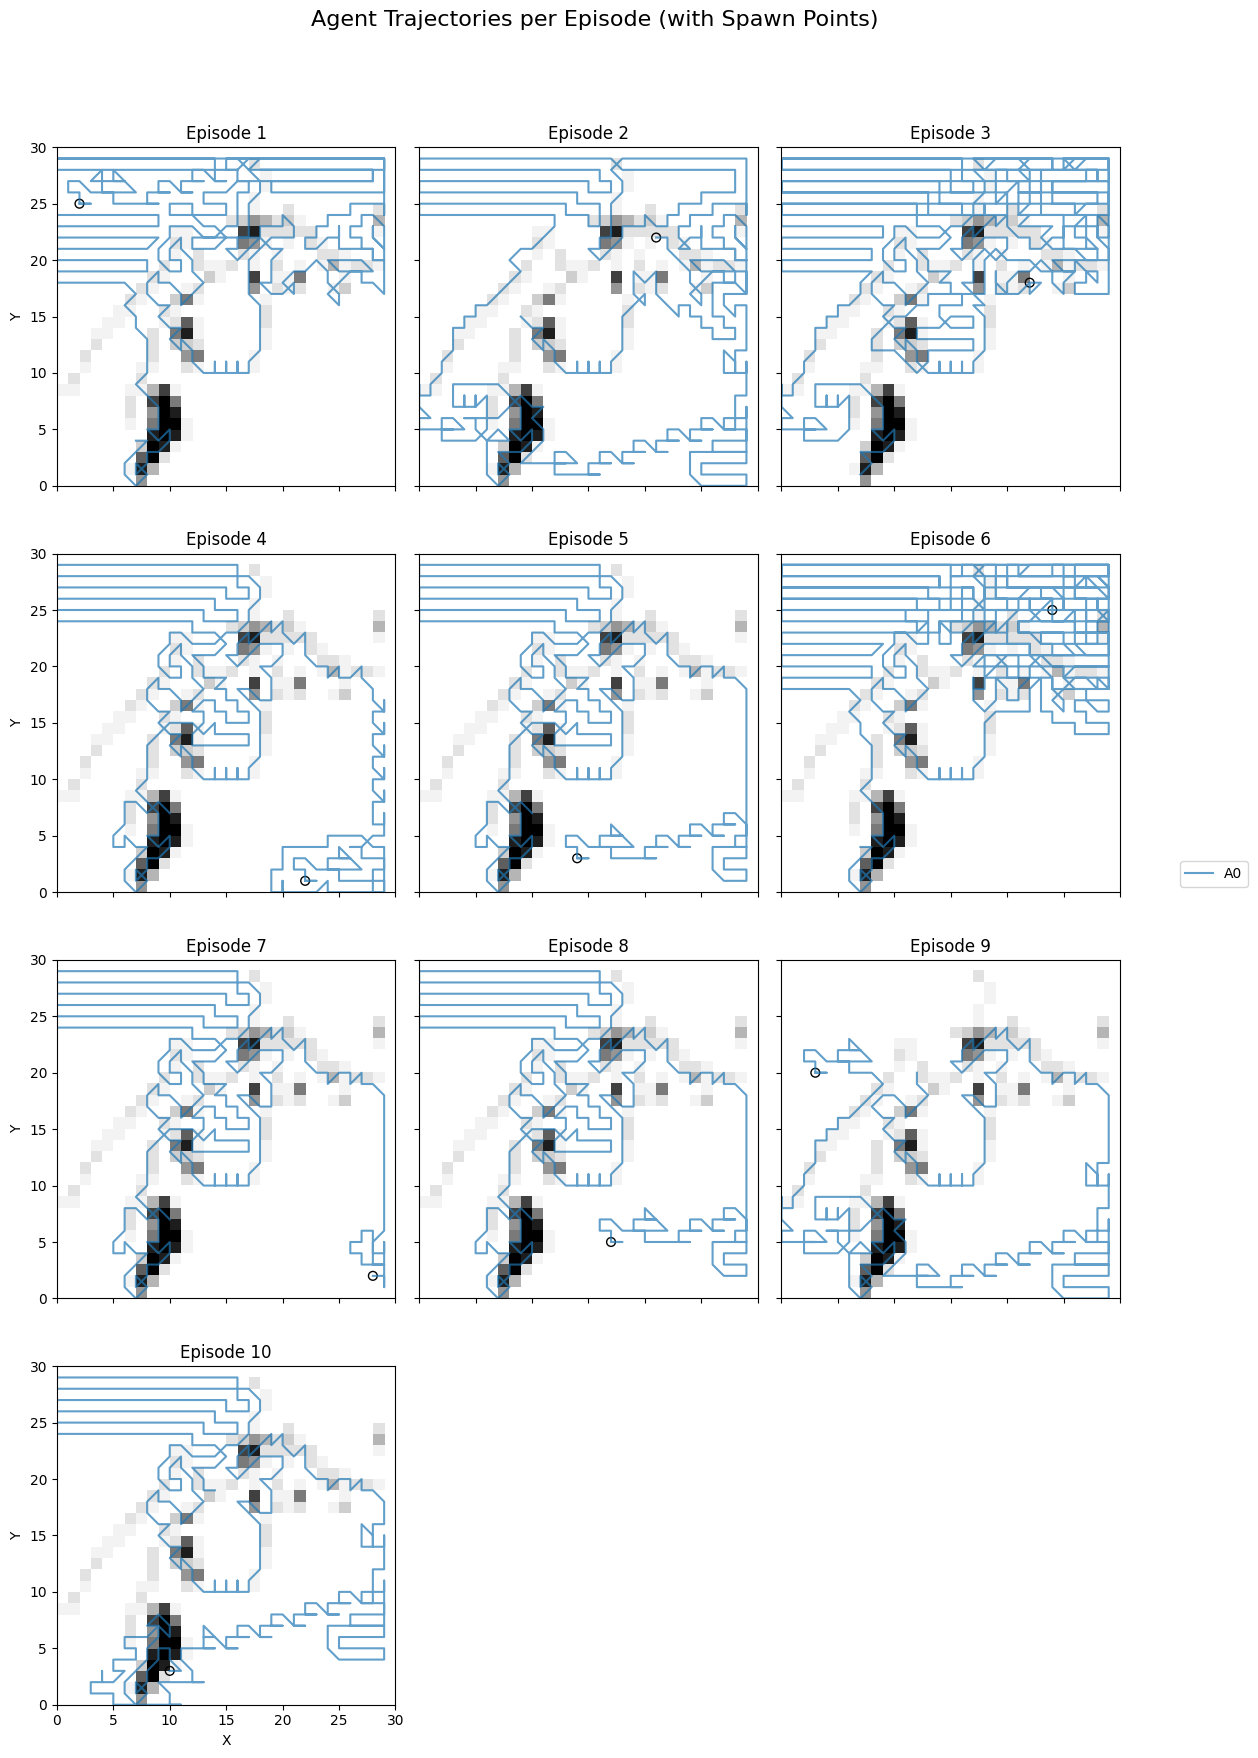

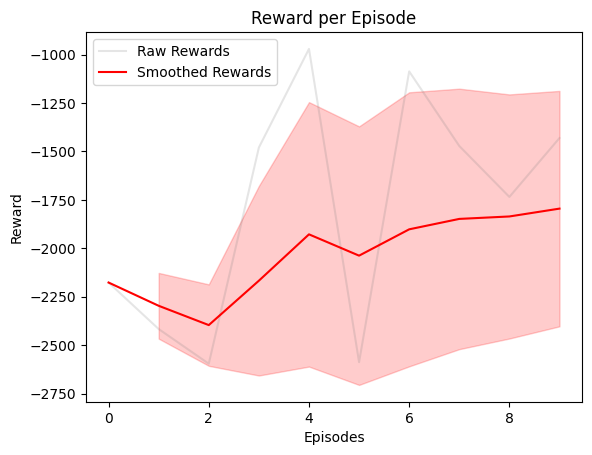

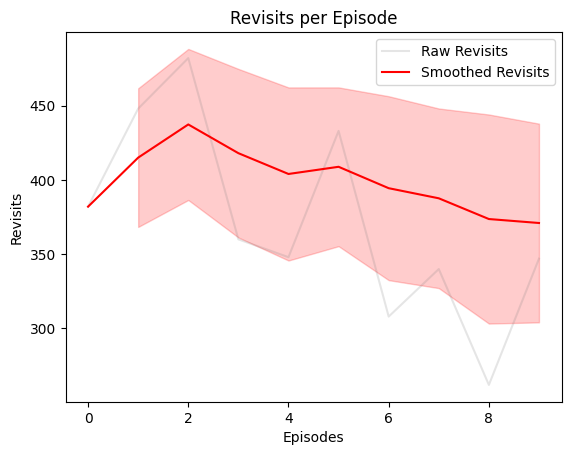

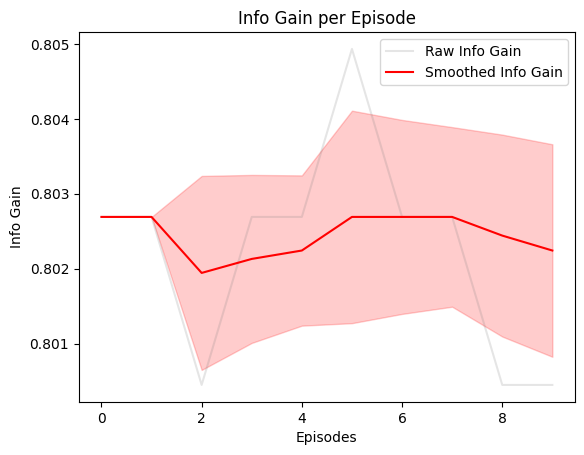

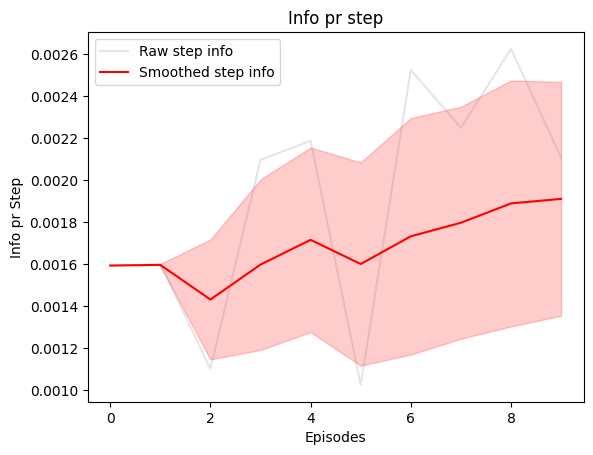

In [327]:
display("Q-table", pd.DataFrame(agent1.q_values))
display(swarm1.info_pr_step)
swarm1.evaluate_swarm(SIZE*SIZE,10)
swarm1.plot_trajectories(env, EVALUATION_EPISODES)
swarm1.plot_reward_episode(EVALUATION_EPISODES)
swarm1.plot_revisited(EVALUATION_EPISODES)
swarm1.plot_info(EVALUATION_EPISODES)
swarm1.plot_info_pr_step(EVALUATION_EPISODES)

In [328]:
agents[0].plot_trajectory(0.005)

KeyboardInterrupt: 